In [1]:
import sys
sys.path.append('/home/jra21/work/source/repos/opep')

In [2]:
from openep import io as openep_io
from openep import case as openep_case
from openep import mesh_routines as openep_mesh
from openep import case_routines as case_routines

import pyvista as pv
import numpy as np


In [3]:
filename = '/home/jra21/work/source/repos/opep/examples/data/new_dataset_2.mat'
ep_case = openep_io.load_case(filename)


In [ ]:
filename = '/home/jra21/work/source/repos/opep/examples/data/new_dataset_1.mat'
ep_case = openep_io.load_case(filename)

In [ ]:
ep_case_mesh = ep_case.create_mesh()
pts = ep_case.nodes
tri = ep_case.indices.astype(int)




In [ ]:
import trimesh as tm

# Freeboundary
tm_mesh = tm.Trimesh(vertices=pts,faces=tri)
freeboundary = tm_mesh.outline().to_dict()
mesh_outline_entities = tm_mesh.outline().entities

freeboundary_vertex_nodes = []
freeboundary_points = []


for i in range(len(mesh_outline_entities)):
    freeboundary_vertex_nodes.append(freeboundary["entities"][i]['points'])

# print(freeboundary_vertex_nodes)

for item in freeboundary_vertex_nodes:
    print(pts[item])

In [ ]:
# mesh = pv.PolyData(pts,tri)


# mesh points
vertices = np.array([[0, 0, 0],
                     [1, 0, 0],
                     [1, 1, 0],
                     [0, 1, 0],
                     [0.5, 0.5, -1]])

# mesh faces
faces = np.hstack([[4, 0, 1, 2, 3],  # square
                   [3, 0, 1, 4],     # triangle
                   [3, 1, 2, 4]])    # triangle

surf = pv.PolyData(vertices, faces)
surf.plot(scalars=np.arange(3), cpos=[-1, 1, 0.5])


In [ ]:
np.set_printoptions(suppress=True)
size_tri = []

x = tri[:,0].reshape(len(tri[:,0]),1)
y = tri[:,1].reshape(len(tri[:,1]),1)
z = tri[:,2].reshape(len(tri[:,2]),1)


for item in tri:
    size_tri.append(len(item))

# size_tri = np.array(size_tri).reshape(len(size_tri),1)

size_tri_list = size_tri
size_tri_arr = np.array(size_tri,dtype=np.int).reshape(len(size_tri),1)

# print('x.shape',x)
# print('y.shape',y)
# print('z.shape',z)
# print('size-tri.shape',size_tri_arr)

face = np.hstack(np.concatenate((size_tri_arr,tri),axis=1))
print(face)

mesh = pv.PolyData(pts,face)
mesh.plot()


In [ ]:
faces = np.hstack([[4, 0, 1, 2, 3],  # quad
                       [3, 0, 1, 4],     # triangle
                       [3, 1, 2, 4],     # triangle
                       [1, 5]]).astype(np.int8)  # vertex
print(faces)

### Get WIndow Of Interest

In [ ]:
def getWindowOfInterest(mesh_case,*args):

# Usage:
# woi = getWindowOfInterest(userdata) - returns the entire array of woi values from the case dataset
# woi = getWindowOfInterest(userdata, 'iEgm', 1) - returns the 1st woi value
# woi = getWindowOfInterest(userdata, 'iEgm', [100,150]) - returns the 100th and 150th woi value
# woi = getWindowOfInterest(userdata, 'iEgm', range(12,20)) - returns a range of woi values starting from 12th to 19th
    
    nStandardArgs = 1
    iEgm = np.array(':')
    
    nargin = len(args)+1
    if nargin>nStandardArgs:
        for i in range(0,(nargin-nStandardArgs),2):
            if np.char.lower(args[i]) == 'iegm':
                iEgm = args[i+1]
    woi = []
    if (type(iEgm)==str) and (np.char.compare_chararrays(iEgm,':','==',True)):
        woi = mesh_case.electric['annotations/woi'].T
        woi = woi.astype(int)
        
    else:
        woi_raw = ep_case.electric['annotations/woi'].T
        woi_raw = woi_raw.astype(int)
        for i in iEgm:
            woi.append(woi_raw[i])
    
    woi = np.array(woi)
    return woi
    

In [ ]:
# iEgm_range = range(12,20)

c = getWindowOfInterest(ep_case,'iegm',':')
print(c)

### Function - lineLength ()

In [ ]:
def lineLength(h):
    
    '''
    Calculates the Length of a line
    
    Args:
        h: mx3 matrix of cartesian co-ordinates representing the line
        the X,Y, Z data are received directly in a matrix of the form:
         [ x_1  y_1  z_1 ]
         [ x_2  y_2  z_2 ]
         [ ...  ...  ... ]
         [ x_n  y_n  z_n ]
         
    Returns:
        l - length of the line as a float
    '''
#   remove any Nan values
    data = h[~np.isnan(h)].reshape(h.shape[0],h.shape[1])
        
    dx = np.diff(data[:,0])
    dy = np.diff(data[:,1])
    dz = np.diff(data[:,2])
    
    l = 0
    for i in range(len(dx)):
        l = l+ np.sqrt(np.square(dx[i]) + np.square(dy[i]) + np.square(dz[i]))
        
    return l

In [ ]:
def drawFreeBoundaries(mesh_case,
                       fb_points,
                       fb_col,
                       fb_width,
                       mesh_surf_color,
                       opacity,
                       smooth_shading,
                       use_transparency,
                       lighting,**kwargs):
    '''
    Draws the boundaries at the edge of a TriSurface mesh
    Args:
        mesh_case         : openep Case object
        fb_points         : m x 3 coordinate point arrays
        fb_width          : Float
        mesh_surf_color   : RGB values scaled between 0 and 1
        opacity           : Float - any value in the range 0-1 
        smooth_shading    : Boolean - True | False  
        use_transparency  : Boolean - True | False
        lighting          : Boolean - True | False
    
    Returns:
        p                 : pyvista plotter handle

    '''
    surf = draw.DrawMap(ep_case,
                        cmap='jet_r',
                        freeboundary_color='black',
                        freeboundary_width=5,
                        minval=0,
                        maxval=2,
                        volt_below_color=0, 
                        volt_above_color=2, 
                        nan_color='Gray',
                        plot=False)
    
    pvmesh = surf['pyvista-mesh']
    p = surf['hsurf']
    
    #     Freeboundary Color
    fb_col = ['blue','yellow','green','red','orange','brown','magenta']
    
    p.add_mesh(pvmesh, 
               color=mesh_surf_color,
               opacity=opacity,
               smooth_shading=smooth_shading,
               use_transparency=use_transparency,
               lighting=lighting)
    
    for indx in range(len(fb_points)):
            p.add_lines(fb_points[indx],
                        color=fb_col[indx],
                        width=fb_width)    
    return p
    

### UseCase09: GetAnatomicalStructure()

In [ ]:
import trimesh as tm
from openep import draw_routines as draw


def getAnatomicalStructures(mesh_case, plot, **kwargs):
    
    '''
    GETANATOMICALSTRUCTURES Returns the free boundaries (anatomical 
    structures) described in ep_case
    
    Args:
        mesh_case : Case
        
    Returns:
        FreeboundaryPoints : m x 3 matrix of the freeboundary coordinate points of each anatomical structure
        l                  : array of lengths [perimeters] of each anatomical structure
        a                  : array of areas of each anatomical structure
        tr                 : array of trimesh objects of each anatomical structure
    
    
    GETANATOMICALSTRUCTURES identifies all the anatomical structures of a 
    given data set. Anatomical structures are boundary regions that have been 
    added to an anatomical model in the clinical mapping system. For example, 
    with respect of left atrial ablation, anatomical structures may represent 
    the pulmonary vein ostia, mitral valve annulus or left atrial appendage 
    ostium.
        
    '''


    x_values = []
    y_values = []
    z_values = []
    
    tr = []
    a = []
    dist = []
    l = []
    
    
    pts = mesh_case.nodes
    face = mesh_case.indices.astype(int)
        
    tm_mesh = tm.Trimesh(vertices=pts,faces=face)
    freeboundary = tm_mesh.outline().to_dict()
    mesh_outline_entities = tm_mesh.outline().entities
    freeboundary_vertex_nodes = []
    freeboundary_points = []


    for i in range(len(mesh_outline_entities)):
        freeboundary_vertex_nodes.append(freeboundary["entities"][i]['points'])


    # mesh Vertices
    trimesh_points = tm_mesh.vertices

    for i in freeboundary_vertex_nodes:
        x_values.append(trimesh_points[i][:,0])
        y_values.append(trimesh_points[i][:,1])
        z_values.append(trimesh_points[i][:,2])

    x_values_array = []
    y_values_array = []
    z_values_array = []


    for i in range(len(mesh_outline_entities)):
        x_values_array.append(x_values[i].reshape(len(x_values[i]),1))
        y_values_array.append(y_values[i].reshape(len(y_values[i]),1))
        z_values_array.append(z_values[i].reshape(len(z_values[i]),1))
        freeboundary_points.append(np.concatenate((x_values_array[i],
                                            y_values_array[i],
                                            z_values_array[i]),
                                            axis=1))

    freeboundary_points = np.array(freeboundary_points,dtype=object)
    
    

    for i in range(len(freeboundary_points)):
        coords = freeboundary_points[i]
        centre = np.round(np.mean(coords,0),3)
        centre = centre.reshape(1,len(centre))

        # Create a Trirep of the boundary
        X = np.vstack((centre,coords))
        numpts = X.shape[0]
        A = np.zeros(((numpts-1),1),dtype=np.int64)
        B = np.array(range(1,numpts)).T
        B = B.reshape(len(B),1)
        C = np.array(range(2,numpts)).T
        C = C.reshape(len(C),1)
        C = np.vstack((C,1))
        TRI = np.concatenate((A,B,C),axis=1)

        for j in range(len(coords)-1):
            dist.append(np.linalg.norm(coords[j+1]-coords[j]))
            

        tr.append(tm.Trimesh(vertices=X,faces=TRI))
        lineLen = lineLength(coords)
        a.append(round(tr[i].area,4))
        l.append(round(lineLen,4))
        print('Perimeter is :',l[i],'| Area is:',a[i])
        
    if plot:
        col = ['blue','yellow','green','red','orange','brown','magenta']
        fb_width = 3
        mesh_surf = [0.5,0.5,0.5]
        p = drawFreeBoundaries(mesh_case=ep_case,
                               fb_points=freeboundary_points,
                               fb_col = col,
                               fb_width = fb_width,
                               mesh_surf_color = mesh_surf,
                               opacity = 0.2,
                               smooth_shading= True,
                               use_transparency=False,
                               lighting=False,
                               **kwargs)
            
    p.background_color='White'
    p.show()
    
        
    return {'FreeboundaryPoints':freeboundary_points,'Lengths':l, 'Area':a, 'tr':tr}

In [ ]:
fbp = getAnatomicalStructures(ep_case,plot=True)

### UseCase37: get_reference_annotation()

In [ ]:
def get_reference_annotation(mesh_case,*args):
    '''
    get_reference_annotation Returns the value of the reference annotation
    
    Args:
        mesh_case: openep case object
        'iegm': str
        {:} (default) | integer | range(start int, stop int)
        
    Returns:
            int value of the reference annotation for the corresponding iegm values
    '''
    
    n_standard_args = 1
    i_egm = np.array(':')
    
    n_arg_in = len(args)+1
    if n_arg_in>n_standard_args:
        for i in range(0,(n_arg_in-n_standard_args),2):
            if np.char.lower(args[i]) == 'iegm':
                i_egm = args[i+1]
    ref = []
    if (type(i_egm)==str) and (np.char.compare_chararrays(i_egm,':','==',True)):
        ref = mesh_case.electric['annotations/referenceAnnot'].T

    else:
        ref_raw = mesh_case.electric['annotations/referenceAnnot'].T
        ref_raw = ref_raw.astype(int)
        
        for i in i_egm:
            ref.append(ref_raw[i])
                        
    
    ref = np.array(ref).astype(int)
    return ref
    

In [ ]:
ref_array = case_routines.get_reference_annotation(ep_case)
print(ref_array)

### UseCase028 - get_egms_at_points()

In [4]:
# Load EGM voltage values
# UseCase 28 - Get the electrogam at a mapping point #39

def get_egms_at_points(mesh_case,*args):
    """
    Access electrogram from stored in the openep data format
    
    Args:
        mesh_case: openep case object
        "iegm": str
        "{:}" (default) |  [egm-indices (int)] | [start-egm-index-point  (int), stop-egm-index-point (int)] 
        
    Returns:
            egm_traces: corresponding list of arrays of size:1x2500 each, containing the 'bip' and 'uni' voltages for the requested points
            sample_range: list of all the sample range within the window-of-interest for the requested points
    """
    

    egm_traces = []
    sample_range = []
    electric_egm_bip = []
    electric_egm_uni = []
    
    n_standard_args = 1
    i_egm = np.array(':')
    n_arg_in = len(args)+1

    buffer = 50
    buffer = [-buffer,buffer]

    woi = mesh_case.electric['annotations/woi'].T.astype(np.int64)
    ref_annot = mesh_case.electric['annotations/referenceAnnot'].T.astype(np.int64)

    if n_arg_in>n_standard_args:
        for i in range(0,(n_arg_in-n_standard_args),2):
            if np.char.lower(args[i]) == 'iegm':
                i_egm = args[i+1]

    if (type(i_egm)==str) and (np.char.compare_chararrays(i_egm,':','==',True)):
        electric_egm_bip = mesh_case.electric["egm"].T
        electric_egm_uni = mesh_case.electric["egmUni"].T
        sample_range = (woi[:] + ref_annot[:]) + buffer

        electric_egm_bip = np.array(electric_egm_bip).astype(float)
        electric_egm_uni = np.array(electric_egm_uni).astype(float)

        egm_traces.append(electric_egm_bip)
        egm_traces.append(electric_egm_uni[:,:,0])
        egm_traces.append(electric_egm_uni[:,:,1]) 


    else:
        electric_egm_bip_raw = mesh_case.electric["egm"].T
        electric_egm_bip_raw = electric_egm_bip_raw.astype(float)
        electric_egm_uni_raw = mesh_case.electric["egmUni"].T
        electric_egm_uni_raw = electric_egm_uni_raw.astype(float)
        
        if len(i_egm)==2:
            start_indx = i_egm[0]
            end_indx = i_egm[1]+1

            if (end_indx > len(electric_egm_bip_raw)):
                raise IndexError('egm index out of range')

            else:
                for i in range(start_indx,end_indx):
                    egm_traces.append(electric_egm_bip_raw[i])
                    egm_traces.append(electric_egm_uni_raw[i,:,0])
                    egm_traces.append(electric_egm_uni_raw[i,:,1])
                    sample_range.append((woi[i] + ref_annot[i])+ buffer )
                egm_traces = egm_traces[::-1]    

        else:
            if (i_egm[0] > (len(electric_egm_bip_raw)-1)):
                raise IndexError('egm index out of range')

            else:
                egm_traces.append(electric_egm_bip_raw[i_egm])
                egm_traces.append(electric_egm_uni_raw[i_egm,:,0])
                egm_traces.append(electric_egm_uni_raw[i_egm,:,1])
                electric_egm_bip.append(electric_egm_bip_raw[i_egm].astype(float))
                electric_egm_uni.append(electric_egm_uni_raw[i_egm].astype(float))
                sample_range = woi[i_egm]+ref_annot[i_egm]
                sample_range = sample_range + buffer

                egm_traces = egm_traces[::-1]

    return {'egm_traces':egm_traces,'sample_range':sample_range}

In [7]:
# Plot EGM

import matplotlib.pyplot as plt

def plot_egm(egmtraces,sample_range):
    """
    Plots the electrogram for a single index point

    Args:
        egmtraces - 3xn array of voltages (bip and uni)
        sample_range - 2x1 list of list of the sample range within the window-of-interest for the requested single point
    
    Returns:
        Plot of the electrogram voltages

    """
    # Plotting the egms
    fig,axs = plt.subplots(nrows=1,ncols=1)
    seperation = 7

    for i in range(len(egmtraces)):
        y = egmtraces[i][0][sample_range[0]:sample_range[1]]
        t = np.arange(sample_range[0],sample_range[1],1)
        axs.plot(t,y+(seperation*i))
        axs.get_yaxis().set_visible(False)
    plt.show()



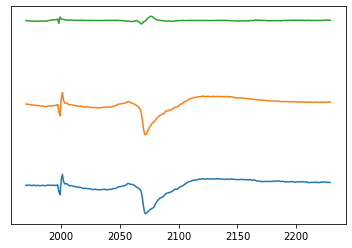

In [8]:
egm = get_egms_at_points(ep_case,"iegm",[0])
egm_t = egm['egm_traces']
egm_sr = egm['sample_range'][0]

plot_egm(egm_t,egm_sr)

